# Embedded ML Lab - Excercise 4 - Pruning

Focus on structured pruning to save computation time. We will do this in three steps. 
* We will use a builtin-function, similar to previous l1 pruning, to sets whole output channels to zero + delete.  

* We will implement a function, similar to previous l1 pruning, to sets whole output channels to zero.  

* We will delete the zeroed-out channels and densify the network again to have a reduction in computation time.

* We will retrain the network to gain accuracy again.  

In [1]:
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [2]:
import torch
from torch import nn
import torch.nn.utils.prune as prune
import torch.nn.functional as F
import torch.nn.utils.prune as prune

# A subset of VOCDataLoader just for one class (person) (0)
from utils.dataloader import VOCDataLoaderPerson

from tinyyolov2 import TinyYoloV2
from tinyyolov2_fused import FusedTinyYoloV2
import tqdm

from typing import Dict, List
import numpy as np
import matplotlib.pyplot as plt
import time

import tqdm
import copy

from utils.ap import ap, precision_recall_levels
from utils.yolo import nms, filter_boxes

train_loader = VOCDataLoaderPerson(train=True, batch_size=128, shuffle=True)
test_loader = VOCDataLoaderPerson(train=False, batch_size=1)

# Utility Functions

## Structured Pruning

In [3]:
def structured_pruning_yolo(model, ratio):
    for name, module in model.named_modules():
        if name == 'conv9':
            continue
        if isinstance(module, torch.nn.Conv2d):
            prune.ln_structured(module, name="weight", amount=ratio, n=1, dim=0)
            prune.remove(module, "weight")

    return model 

In [4]:
def count_pruned_weights(model):
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Conv2d):
            total_weights = module.weight.nelement()
            zero_weights = torch.sum(module.weight == 0).item()
            percentage = (zero_weights / total_weights) * 100
            
            print(f"{name}: {zero_weights}/{total_weights} weights are 0 ({percentage:.2f}%)")

In [5]:
def densify_model(model):
    """
    Entfernt geprunte Filter aus Conv2d-Schichten und passt BatchNorm2d und Eingabekanäle der nachfolgenden Schichten an.
    """
    new_model = copy.deepcopy(model)
    conv_layers = []
    bn_layers = {}
    channel_map = {}

    # save all conv and bn layers
    for name, module in model.named_children():
        if isinstance(module, nn.Conv2d):
            conv_layers.append(name)
        elif isinstance(module, nn.BatchNorm2d):
            corresponding_conv = f"conv{name[-1]}"
            bn_layers[name] = corresponding_conv

    # densify all pruned channels
    for name in conv_layers:
        module = getattr(new_model, name)
        weight = module.weight.detach().clone()
        nonzero_filters = torch.any(weight != 0, dim=(1, 2, 3))
        new_out_channels = nonzero_filters.sum().item()

        if new_out_channels == module.out_channels:
            channel_map[name] = new_out_channels
            continue

        print(f"Densifying {name}: {module.out_channels} -> {new_out_channels} channels")

        new_conv = nn.Conv2d(
            in_channels=module.in_channels,
            out_channels=new_out_channels,
            kernel_size=module.kernel_size,
            stride=module.stride,
            padding=module.padding,
            bias=(module.bias is not None)
        )

        new_conv.weight.data = weight[nonzero_filters].clone()
        if module.bias is not None:
            new_conv.bias.data = module.bias.data[nonzero_filters].clone()

        setattr(new_model, name, new_conv) # replace with new conv
        channel_map[name] = new_out_channels

        # adapt corresponding batchnorm layer
        bn_name = f"bn{name[-1]}"
        if bn_name in bn_layers:
            bn_module = getattr(new_model, bn_name)
            new_bn = nn.BatchNorm2d(new_out_channels)
            new_bn.running_mean = bn_module.running_mean[:new_out_channels].clone()
            new_bn.running_var = bn_module.running_var[:new_out_channels].clone()
            new_bn.weight.data = bn_module.weight[:new_out_channels].clone()
            new_bn.bias.data = bn_module.bias[:new_out_channels].clone()
            setattr(new_model, bn_name, new_bn)

    # adapt input channels
    for idx in range(len(conv_layers) - 1):
        curr_conv = conv_layers[idx]
        next_conv = conv_layers[idx + 1]

        new_in_channels = channel_map.get(curr_conv, getattr(new_model, curr_conv).out_channels)
        next_conv_module = getattr(new_model, next_conv)

        if next_conv_module.in_channels != new_in_channels:
            print(f"Updating {next_conv} in_channels: {next_conv_module.in_channels} -> {new_in_channels}")
            
            # new conv layer with adapted input channels
            new_next_conv = nn.Conv2d(
                in_channels=new_in_channels,
                out_channels=next_conv_module.out_channels,
                kernel_size=next_conv_module.kernel_size,
                stride=next_conv_module.stride,
                padding=next_conv_module.padding,
                bias=(next_conv_module.bias is not None)
            )

            weight = next_conv_module.weight.detach().clone()
            new_next_conv.weight.data = weight[:, :new_in_channels, :, :].clone()
            if next_conv_module.bias is not None:
                new_next_conv.bias.data = next_conv_module.bias.data.clone()

            setattr(new_model, next_conv, new_next_conv) # replace with new conv

    return new_model


In [6]:
def plot(data, xlabel='Execution time', save_path='plot.png'):
   
    data = copy.deepcopy(data)
    for (x, y, label) in data:
        x = np.array(x)/max(x)
        plt.plot(x, y, label=label, alpha=0.5)
        plt.scatter(x, y, alpha=0.5)
        
    plt.ylabel('Accuracy')
    plt.xlabel(xlabel)
    plt.legend()
        
    plt.savefig(save_path)
    plt.show()

In [7]:
def net_time(net, test_loader):
    net.eval()

    t_start = time.time()

    for _, (inputs, _) in enumerate(test_loader):
        net.forward(inputs)
        break

    t_end = time.time()
    t = t_end - t_start

    return t

# Finetuned model

In [8]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch_device = torch.device("cuda")
sd = torch.load('./weights/voc_fine_tuned.pt', weights_only=True, map_location=torch_device)

model = TinyYoloV2(num_classes=1)
model.load_state_dict(sd, strict=False)

# count_pruned_weights(model)
model_sd = model.state_dict()

# for layer_key in model_sd:
#     print(layer_key)
#     print(model_sd[layer_key].shape)
#     print("")

In [9]:
print(f"\nInference Time before Pruning: {net_time(model, test_loader):.3}")


Inference Time before Pruning: 0.273


/opt/conda/lib/python3.11/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


## L1 Pruning (local)

In [10]:
model_pruned = structured_pruning_yolo(model, 0.3)
# count_pruned_weights(model)

model_densed = densify_model(model_pruned)
model_densed_sd = model_densed.state_dict()

# for layer_key in model_densed_sd:
#     print(layer_key)
#     print(model_densed_sd[layer_key].shape)
#     print("")

# print(f"Original Model Size: {sum(p.numel() for p in model_pruned.parameters())}")
# print(f"Densified Model Size: {sum(p.numel() for p in model_densed.parameters())}")

Densifying conv1: 16 -> 11 channels
Densifying conv2: 32 -> 22 channels
Densifying conv3: 64 -> 45 channels
Densifying conv4: 128 -> 90 channels
Densifying conv5: 256 -> 179 channels
Densifying conv6: 512 -> 358 channels
Densifying conv7: 1024 -> 717 channels
Densifying conv8: 1024 -> 717 channels
Updating conv2 in_channels: 16 -> 11
Updating conv3 in_channels: 32 -> 22
Updating conv4 in_channels: 64 -> 45
Updating conv5 in_channels: 128 -> 90
Updating conv6 in_channels: 256 -> 179
Updating conv7 in_channels: 512 -> 358
Updating conv8 in_channels: 1024 -> 717
Updating conv9 in_channels: 1024 -> 717


In [11]:
print(f"\nInference Time after Densifying: {net_time(model_densed, test_loader):.3}")


Inference Time after Densifying: 0.202


100%|██████████| 15/15 [01:10<00:00,  4.67s/it]


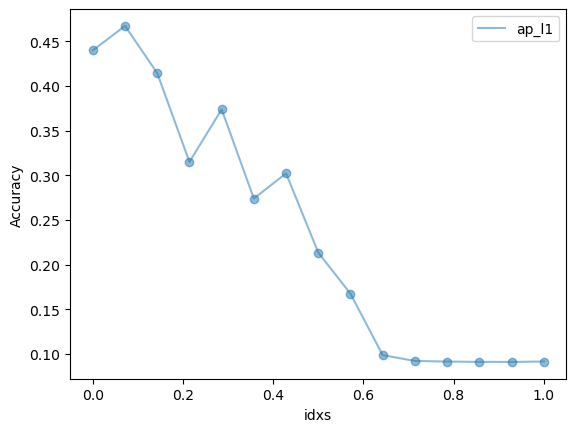

In [12]:
ratios = np.linspace(0, 0.8, 15)

sd = torch.load('./weights/voc_fine_tuned.pt', weights_only=True, map_location=torch_device)
accuracy_l1, idxs = [], []
for idx, ratio in tqdm.tqdm(enumerate(ratios), total=len(ratios)):
    model = TinyYoloV2(num_classes=1)
    model.load_state_dict(sd, strict=False)
    
    structured_pruning_yolo(model, ratio)

    test_precision, test_recall = [], []
    with torch.no_grad():
        for i, (input, target) in enumerate(test_loader):
            output = model(input, yolo=True)
            
            #The right threshold values can be adjusted for the target application
            output = filter_boxes(output, 0.0)
            output = nms(output, 0.5)
            
            precision, recall = precision_recall_levels(target[0], output[0])
            test_precision.append(precision)
            test_recall.append(recall)
            if i == 32:
                break
    
    accuracy_l1.append(ap(test_precision, test_recall))
    idxs.append(idx)
plot([(idxs, accuracy_l1, 'ap_l1')], xlabel='idxs', save_path='ap_l1.png')

# Finetuned fused model

In [13]:
sd = torch.load('./weights/fused_voc_fine_tuned.pt', weights_only=True, map_location=torch_device)

model_fused = FusedTinyYoloV2(num_classes=1)
model_fused.load_state_dict(sd, strict=False)

count_pruned_weights(model_fused)

model_fused_sd = model.state_dict()

conv1: 0/432 weights are 0 (0.00%)
conv2: 0/4608 weights are 0 (0.00%)
conv3: 0/18432 weights are 0 (0.00%)
conv4: 0/73728 weights are 0 (0.00%)
conv5: 0/294912 weights are 0 (0.00%)
conv6: 0/1179648 weights are 0 (0.00%)
conv7: 0/4718592 weights are 0 (0.00%)
conv8: 0/9437184 weights are 0 (0.00%)
conv9: 0/30720 weights are 0 (0.00%)


In [14]:
print(f"\nInference Time before Pruning: {net_time(model_fused, test_loader):.3}")


Inference Time before Pruning: 0.0139


## L1 Pruning (local)

In [15]:
model_fused_pruned = structured_pruning_yolo(model, 0.3)
# count_pruned_weights(model)

model_fused_densed = densify_model(model_pruned)
model_fused_densed_sd = model_densed.state_dict()

# for layer_key in model_densed_sd:
#     print(layer_key)
#     print(model_densed_sd[layer_key].shape)
#     print("")

# print(f"Original Model Size: {sum(p.numel() for p in model_pruned.parameters())}")
# print(f"Densified Model Size: {sum(p.numel() for p in model_densed.parameters())}")

Densifying conv1: 16 -> 11 channels
Densifying conv2: 32 -> 22 channels
Densifying conv3: 64 -> 45 channels
Densifying conv4: 128 -> 90 channels
Densifying conv5: 256 -> 179 channels
Densifying conv6: 512 -> 358 channels
Densifying conv7: 1024 -> 717 channels
Densifying conv8: 1024 -> 717 channels
Updating conv2 in_channels: 16 -> 11
Updating conv3 in_channels: 32 -> 22
Updating conv4 in_channels: 64 -> 45
Updating conv5 in_channels: 128 -> 90
Updating conv6 in_channels: 256 -> 179
Updating conv7 in_channels: 512 -> 358
Updating conv8 in_channels: 1024 -> 717
Updating conv9 in_channels: 1024 -> 717


In [16]:
print(f"\nInference Time after Densifying: {net_time(model_fused_densed, test_loader):.3}")


Inference Time after Densifying: 0.0136


100%|██████████| 15/15 [01:07<00:00,  4.52s/it]


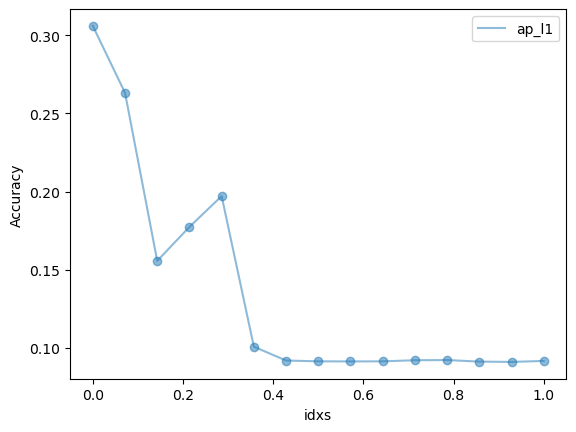

In [17]:
ratios = np.linspace(0, 0.8, 15)

sd = torch.load('./weights/fused_voc_fine_tuned.pt', weights_only=True, map_location=torch_device)
accuracy_l1, idxs = [], []
for idx, ratio in tqdm.tqdm(enumerate(ratios), total=len(ratios)):
    model = TinyYoloV2(num_classes=1)
    model.load_state_dict(sd, strict=False)
    
    structured_pruning_yolo(model, ratio)

    test_precision, test_recall = [], []
    with torch.no_grad():
        for i, (input, target) in enumerate(test_loader):
            output = model(input, yolo=True)
            
            #The right threshold values can be adjusted for the target application
            output = filter_boxes(output, 0.0)
            output = nms(output, 0.5)
            
            precision, recall = precision_recall_levels(target[0], output[0])
            test_precision.append(precision)
            test_recall.append(recall)
            if i == 32:
                break
    
    accuracy_l1.append(ap(test_precision, test_recall))
    idxs.append(idx)
plot([(idxs, accuracy_l1, 'ap_l1')], xlabel='idxs', save_path='ap_l1.png')